# Figure 2: basin sizes

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

sys.path.append("../code/")

from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

## Linear stability

In [2]:


# more intense
colors = sb.color_palette("rocket", n_colors=5)
#colors = sb.color_palette("mako_r", n_colors=5)

# more mellow
#colors = sb.color_palette("flare", n_colors=5)
#colors = sb.color_palette("crest", n_colors=5)


# Directed hypergraphs
def lambda2_HG(N,K1,K2,q,r):
    a = np.zeros(r+1) #contribution from pairwise interactions
    b = np.zeros(r+1) #contribution from triadic interactions

    for s in range(1,r+1):
        a[s] = K1*np.cos(2*np.pi*q*s/N)/2/r
        for k in range(-r,r+1):
            b[s] += np.cos(2*np.pi*q*(s+k)/N)
        b[s] = b[s] - np.cos(2*np.pi*q*s/N) - np.cos(4*np.pi*q*s/N)

    b = K2*b/(r*(2*r-1))
    c = a+b #vector for J_s
    c[0] = -2*np.sum(c)

    Lambda = np.zeros(N, dtype=np.complex_)
    for p in range(N):
        Lambda[p] = c[0]
        for s in range(1,r+1):
            Lambda[p] = Lambda[p] + c[s]*np.exp(2J*np.pi*p*s/N) + c[s]*np.exp(2J*np.pi*p*(N-s)/N) #calculate the eigenvalues of the Jacobian

    lambda_2 = np.sort_complex(Lambda[1:])[-1] #get the largest nonzero eigenvalue

    return lambda_2


# Simplicial complexes
def lambda2_SC(N,K1,K2,q,r):
    a = np.zeros(r+1)
    b = np.zeros(r+1)

    for s in range(1,r+1):
        a[s] = K1*np.cos(2*np.pi*q*s/N)/2/r
        for k in range(s-r,r+1):
            b[s] += np.cos(2*np.pi*q*(s+k)/N)
        b[s] = b[s] - np.cos(2*np.pi*q*s/N) - np.cos(4*np.pi*q*s/N)
    
    b = 2*K2*b/(3*r*(r-1))
    c = a+b
    c[0] = -2*np.sum(c)

    Lambda = np.zeros(N, dtype=np.complex_)
    for p in range(N):
        Lambda[p] = c[0]
        for s in range(1,r+1):
            Lambda[p] = Lambda[p] + c[s]*np.exp(2J*np.pi*p*s/N) + c[s]*np.exp(2J*np.pi*p*(N-s)/N)

    lambda_2 = np.sort_complex(Lambda[1:])[-1]

    return lambda_2

In [3]:
# Calculate lambda2 for different triadic coupling strengths K2
m = 5
N = 83
r = 2
K1 = 1
#K2 = [0, 10, 20, 30, 40]
K2 = range(m)
Lambda_2 = np.zeros((N,m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        #Lambda_2[q,j] = lambda2_HG(N,K1,K2[j],q,r)
        Lambda_2[q,j] = lambda2_SC(N,K1,K2[j],q,r)

In [4]:
from labellines import labelLine, labelLines


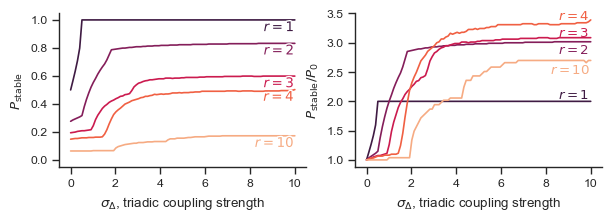

In [5]:
# Calculate the fraction of stable twisted states for different coupling range r
m = 100
N = 830
r = [1, 2, 3, 4, 10]
K1 = 1
K2 = np.linspace(0, 10, num=m)

# Uncomment below if you want to generate the data yourself
# Lambda_2 = np.zeros((N,m,7), dtype=np.complex_)
# for q in range(N):
#    for j in range(m):
#        for i in range(7):
#           Lambda_2[q,j,i] = lambda2_HG(N,K1,K2[j],q,r[i])
#           #Lambda_2[q,j,i] = lambda2_SC(N,K1,K2[j],q,r[i])
# stable_fraction = np.mean(Lambda_2<0, axis=0)

# np.save(f'HG_r_stable_fraction.npy', stable_fraction)
stable_fraction = np.load("HG_r_stable_fraction.npy")
stable_fraction = np.delete(
    stable_fraction, [4, 5], 1
)  # removing r=6 and r=8 from the data

# Plot Fig.5 in the paper
fig, axs = plt.subplots(1, 2, figsize=(7, 2))


x_pos = [0.9, 0.9, 0.9, 0.9, 0.9]
y_pos = [0.92, 0.77, 0.63, 0.44, 0.2]

ax = axs[0]
ax.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax.set_ylabel(r"$P_\mathrm{stable}$")

for i in range(5):
    ax.plot(
        K2,
        stable_fraction[:, i],
        linestyle="-",
        color=colors[i],
        alpha=1,
        label=f"$r={r[i]}$",
    )
    # ax.text(x_pos[i], y_pos[i], f'$r={r[i]}$', color=colors[i], ha='center', va='center', transform=ax.transAxes)

lines = ax.get_lines()
xvals = [10]*5
labelLines(ax.get_lines(), align=False, xvals=xvals, ha="right", yoffsets=-0.055, outline_width=2)

ax = axs[1]

x_pos = [0.95]*5
y_pos = [.47,.76,.87,.98,.63]

for i in range(5):
    ax.plot(K2, stable_fraction[:,i]/stable_fraction[0,i], linestyle='-', color=colors[i], alpha=1, label=f'$r={r[i]}$')
    ax.text(x_pos[i], y_pos[i], f'$r={r[i]}$', color=colors[i], ha='right', va='center', transform=ax.transAxes)

ax.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax.set_ylabel(r"$P_\mathrm{stable}/P_0$")

axs[0].set_ylim(-0.05, 1.05)


sb.despine()


In [6]:
N = 83
nreps = 1000

#rs = [1, 2, 3, 4, 8, 10, 12]
rs = [1, 2, 3, 4, 10]

In [7]:
#file_name = f"../data/freq.txt"

#k2s = np.arange(0, 5, 0.5)

#df = pd.read_csv(file_name, sep=" ")
#df["k2"] = k2s
#df = df.melt(id_vars="k2", value_name="proba", var_name="q")
#df["q"] = df["q"].astype(int)
#df["state"] = df["q"].apply(lambda x: "non-twist" if x > 98 else f"{x}-twisted")
#df["ostate"] = df["q"].apply(lambda x: "non-twist" if x > 98 else f"$q={x}$")

# for loading results in the other format, uncomment the following
#run_dir = f"{results_dir}run_ring_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}/"
#file_name = f"{run_dir}df_long_ring_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.csv"

dfs = []

for r in rs:
    suf = f"ring_r_{r}_sym"  # "di"
    run_dir = f"{results_dir}run_k1_1_k2s_ic_random_tend_800.0_nreps_{nreps}_{suf}/"
    file_name = f"{run_dir}df_long_k1_1_k2s_ic_random_tend_800.0_nreps_{nreps}_{suf}.csv"
    
    #run_dir = f"{results_dir}run_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}/"
    #file_name = f"{run_dir}df_long_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.csv"
    df_r = pd.read_csv(file_name, index_col=0)
    df_r["r"] = r

    dfs.append(df_r)
    

df = pd.concat(dfs)
df = df.reset_index()

df

,index,k2,state,proba,r
0,0,0.00,-1-twisted,0.187,1
1,1,0.25,-1-twisted,0.167,1
2,2,0.50,-1-twisted,0.153,1
3,3,0.75,-1-twisted,0.119,1
4,4,1.00,-1-twisted,0.052,1
...,...,...,...,...,...
2395,95,3.75,other,0.264,10
2396,96,4.00,other,0.316,10
2397,97,4.25,other,0.318,10
2398,98,4.50,other,0.376,10


In [8]:
df["q"] = df["state"].apply(lambda x: int(x[:-8]) if "twisted" in x else None)
df["k"] = df["state"].apply(lambda x: int(x[:-8]) if "cluster" in x else None)

df["state"] = df["state"].replace("sync", "0-twisted")

def agg_state(state):
    if "twisted" in state:
        return "twisted"
    elif "cluster" in state:
        return "2-cluster"
    elif state=="other":
        return "other"
    else:
        print(state, "?")

df["state agg."] = df["state"].apply(agg_state)

df

,index,k2,state,proba,r,q,k,state agg.
0,0,0.00,-1-twisted,0.187,1,-1.0,NaN,twisted
1,1,0.25,-1-twisted,0.167,1,-1.0,NaN,twisted
2,2,0.50,-1-twisted,0.153,1,-1.0,NaN,twisted
3,3,0.75,-1-twisted,0.119,1,-1.0,NaN,twisted
4,4,1.00,-1-twisted,0.052,1,-1.0,NaN,twisted
...,...,...,...,...,...,...,...,...
2395,95,3.75,other,0.264,10,NaN,NaN,other
2396,96,4.00,other,0.316,10,NaN,NaN,other
2397,97,4.25,other,0.318,10,NaN,NaN,other
2398,98,4.50,other,0.376,10,NaN,NaN,other


In [9]:
mask_pos = (df["q"] >= 0) + (df["q"].isna())
mask_nobig = (98 < df["q"]) + (df["q"] < 4) + (df["q"].isna())
mask_twisted = df["state agg."] == "twisted"
mask_cluster = df["state agg."] == "cluster"
mask_other = df["state agg."] == "other"


df[mask_nobig].state.unique()

array(['-1-twisted', '-2-twisted', '-3-twisted', '-4-twisted',
       '-5-twisted', '-6-twisted', '0-twisted', '1-twisted', '2-twisted',
       '3-twisted', '-7-twisted', '-8-twisted', '-9-twisted',
       '-10-twisted', 'other', '-13-twisted', '-15-twisted',
       '-16-twisted', '-20-twisted', '-21-twisted', '-23-twisted',
       '-24-twisted', '-27-twisted', '-28-twisted', '-29-twisted',
       '-32-twisted', '-34-twisted', '-11-twisted', '-12-twisted',
       '-14-twisted', '-17-twisted', '-18-twisted', '-19-twisted',
       '-22-twisted', '-26-twisted', '-30-twisted', '-33-twisted',
       '-35-twisted', '-37-twisted', '-38-twisted', '-39-twisted',
       '-40-twisted', '-41-twisted', '-25-twisted', '-31-twisted',
       '-36-twisted', '2-cluster'], dtype=object)

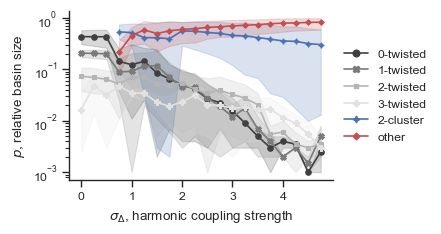

In [10]:
# labels = [f"{i}-twisted" for i in range(5)] + ["other"]
unique_states = sorted(
    [i for i in df[mask_pos * mask_nobig].state.unique() if "twisted" in i]
)

#df["state"] = df["state"].replace("other", "twisted 2-cluster")

labels = unique_states + ["2-cluster", "other"]

fig, ax = plt.subplots(figsize=(3.4, 2.2))
g = sb.lineplot(
    data=df[mask_pos * mask_nobig],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="state",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["b", "r"],
    legend=True,
)

g.set(yscale="log")

ax.set_xlabel(r"$\sigma_{\Delta}$, harmonic coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
#ax.set_ylim(ymin=5e-4, ymax=1.2)

sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="")

#coupling_str = r"$\sigma \, \sin (\theta_j - \theta_i) + \sigma_{\Delta} \, \sin (2\theta_j - 2\theta_i)$"
#ax.set_title(coupling_str)

# plt.savefig(f"{results_dir}figure_2.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
#plt.savefig(f"{results_dir}figure_2_{suf}.png", dpi=250, bbox_inches="tight", pad_inches=0.03)

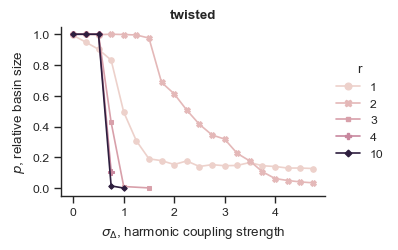

In [11]:
fig, ax = plt.subplots(figsize=(3.4, 2.2))
g = sb.lineplot(
    data=df[mask_nobig * mask_twisted],
    x="k2",
    y="proba",
    hue="r",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="r",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    #palette=sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["b", "r"],
    legend=True,
    estimator="sum",
    ci=None
)

#g.set(yscale="log")

ax.set_xlabel(r"$\sigma_{\Delta}$, harmonic coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
#ax.set_ylim(ymin=5e-4, ymax=1.2)

title = "twisted"
ax.set_title(title, weight="bold")

ax.set_ylim(ymin=-0.05, ymax=1.05)

sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="r")

#plt.savefig(f"{results_dir}basin_size_ring_HG_{title}.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
#plt.savefig(f"{results_dir}figure_2_{suf}.png", dpi=250, bbox_inches="tight", pad_inches=0.03)

## Combined

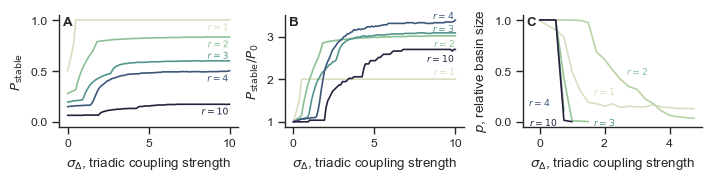

In [16]:
# Calculate the fraction of stable twisted states for different coupling range r
m = 100
N = 830
r = [1, 2, 3, 4, 10]
K1 = 1
K2 = np.linspace(0, 10, num=m)

colors = sb.cubehelix_palette(start=0.5, rot=-0.75, n_colors=5)
# sb.color_palette("crest", n_colors=5)

# Uncomment below if you want to generate the data yourself
# Lambda_2 = np.zeros((N,m,7), dtype=np.complex_)
# for q in range(N):
#    for j in range(m):
#        for i in range(7):
#           Lambda_2[q,j,i] = lambda2_HG(N,K1,K2[j],q,r[i])
#           #Lambda_2[q,j,i] = lambda2_SC(N,K1,K2[j],q,r[i])
# stable_fraction = np.mean(Lambda_2<0, axis=0)

# np.save(f'HG_r_stable_fraction.npy', stable_fraction)
stable_fraction = np.load("HG_r_stable_fraction.npy")
stable_fraction = np.delete(
    stable_fraction, [4, 5], 1
)  # removing r=6 and r=8 from the data

# Plot Fig.5 in the paper
fig, axs = plt.subplots(1, 3, figsize=(7, 1.7), layout="constrained")


x_pos = [0.9, 0.9, 0.9, 0.9, 0.9]
y_pos = [0.92, 0.77, 0.63, 0.44, 0.2]

ax = axs[0]
ax.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax.set_ylabel(r"$P_\mathrm{stable}$")

for i in range(5):
    ax.plot(
        K2,
        stable_fraction[:, i],
        linestyle="-",
        # marker="o",
        # ms=2,
        color=colors[i],
        alpha=1,
        label=f"$r={r[i]}$",
    )
    # ax.text(x_pos[i], y_pos[i], f'$r={r[i]}$', color=colors[i], ha='center', va='center', transform=ax.transAxes)

lines = ax.get_lines()
xvals = [10] * 5
labelLines(
    ax.get_lines(),
    align=False,
    xvals=xvals,
    ha="right",
    yoffsets=[-0.067,-0.067, +0.055, -0.071, -0.066] ,
    outline_width=2,
    fontsize="x-small",
)

ax = axs[1]

x_pos = [0.95] * 5
y_pos = [0.5, 0.75, 0.88, 1, 0.62]

for i in range(5):
    ax.plot(
        K2,
        stable_fraction[:, i] / stable_fraction[0, i],
        linestyle="-",
        color=colors[i],
        alpha=1,
        label=f"$r={r[i]}$",
    )
    ax.text(
        x_pos[i],
        y_pos[i],
        f"$r={r[i]}$",
        color=colors[i],
        ha="right",
        va="center",
        transform=ax.transAxes,
        fontsize="x-small",
    )

ax.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax.set_ylabel(r"$P_\mathrm{stable}/P_0$")

axs[0].set_ylim(-0.05, 1.05)

#### panel c

g = sb.lineplot(
    data=df[mask_nobig * mask_twisted],
    x="k2",
    y="proba",
    hue="r",
    markers=False,
    ax=axs[2],
    # alpha=0.7,
    style="r",
    dashes=False,
    hue_order=labels,
    ms=2,
    mec=None,
    # mfc="w",
    palette=sb.cubehelix_palette(start=0.5, rot=-0.75, as_cmap=True),
    legend=False,
    estimator="sum",
    ci=None,
)

# g.set(yscale="log")

axs[2].set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")
axs[2].set_ylabel("$p$, relative basin size")

# ax.set_ylim(ymin=5e-4, ymax=1.2)

axs[2].set_ylim(ymin=-0.05, ymax=1.05)
axs[2].set_xlim(xmin=-0.5)

#plt.subplots_adjust(wspace=0.4)

# sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="r")


x_pos = [2, 3, 2, 0, 0.1]
y_pos = [0.3, 0.5, 0, 0.2, 0]

for i in range(5):
    # axs[2].plot(K2, stable_fraction[:,i]/stable_fraction[0,i], linestyle='-', color=colors[i], alpha=1, label=f'$r={r[i]}$')
    axs[2].text(
        x_pos[i],
        y_pos[i],
        f"$r={r[i]}$",
        color=colors[i],
        ha="center",
        va="center",
        fontsize="x-small",
    )

sb.despine()

for i, ax in enumerate(axs):
    letters = ["A", "B", "C"]
    ax.text(0.02, 1.01-0.1, f"{letters[i]}", ha="left", transform=ax.transAxes, weight="bold")

plt.savefig(f"{results_dir}figure_5_coupling_range.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_5_coupling_range.png", dpi=250, bbox_inches="tight", pad_inches=0.03)




plt.show()

In [17]:
dff = df[mask_pos * mask_nobig * mask_twisted]
msk = (dff["r"]==2) * (dff["k2"]==0.25)

dff[msk]

,index,k2,state,proba,r,q,k,state agg.
1761,81,0.25,0-twisted,0.328,2,0.0,NaN,twisted
1781,101,0.25,1-twisted,0.243,2,1.0,NaN,twisted
1801,121,0.25,2-twisted,0.083,2,2.0,NaN,twisted
1821,141,0.25,3-twisted,0.014,2,3.0,NaN,twisted


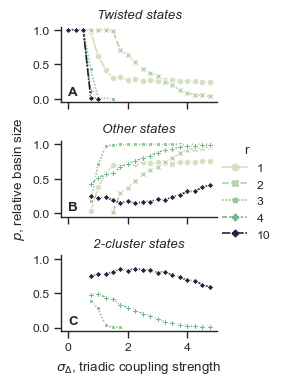

In [19]:
g = sb.relplot(
    kind="line", 
    data=df,
    x="k2",
    y="proba",
    hue="r",
    row="state agg.",
    style="r",
    height=1.3, 
    aspect=1.8,
    markers=True,
    estimator="sum",
    palette=sb.cubehelix_palette(start=0.5, rot=-0.75, as_cmap=True),
    ci=None
)

#g.fig.suptitle(f"N_{N}, nreps={nreps}, ring diHG")
#plt.subplots_adjust(top=0.9)

#g.set(yscale="log")

g.axes[-1,0].set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")
g.axes[0,0].set_ylabel(" ")
g.axes[1,0].set_ylabel("$p$, relative basin size")
g.axes[2,0].set_ylabel(" ")

g.axes[0,0].set_title("Twisted states", style="italic")
g.axes[1,0].set_title("Other states", style="italic")
g.axes[2,0].set_title("2-cluster states", style="italic")

for i, ax in enumerate(g.axes[:,0]):
    letters = ["A", "B", "C"]
    ax.text(0.15, 0.05, f"{letters[i]}", ha="center", weight="bold")


#plt.savefig(f"{results_dir}basin_size_ring_HG_N_{N}_nreps_{nreps}_.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_S4_coupling_range.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_SM_coupling_range.png", dpi=250, bbox_inches="tight", pad_inches=0.03)


plt.show()

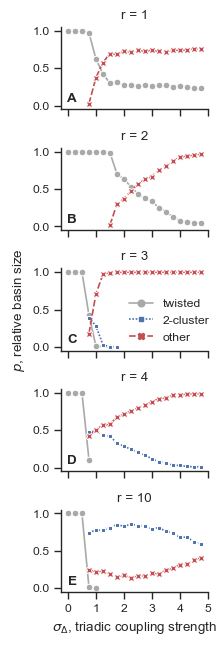

In [20]:
g = sb.relplot(
    kind="line", 
    data=df,
    x="k2",
    y="proba",
    row="r",
    hue="state agg.",
    style="state agg.",
    height=1.3, 
    aspect=1.8,
    markers=True,
    hue_order=["twisted", "2-cluster", "other"],
    estimator="sum",
    palette=["darkgrey", "b", "r"],
    ci=None,
)

g.axes[-1,0].set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")
for i, ax in enumerate(g.axes[:,0]):
    ax.set_ylabel("$p$, relative basin size")
    if i!=2:
        ax.set_ylabel(" ")
    
for i, ax in enumerate(g.axes[:,0]):
    letters = ["A", "B", "C", "D", "E", "F"]
    ax.text(0.15, 0.05, f"{letters[i]}", ha="center", weight="bold")
    
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    
sb.move_legend(g, loc="center right", title="", bbox_to_anchor=(0.75, 0.5))

#g.fig.suptitle(f"N_{N}, nreps={nreps}, ring diHG")
#plt.subplots_adjust(top=0.9)

#plt.savefig(f"{results_dir}basin_size_ring_HG_N_{N}_nreps_{nreps}_v2.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_S5_coupling_range.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_S5_coupling_range.png", dpi=250, bbox_inches="tight", pad_inches=0.03)


In [111]:

g.axes[-1,0]

<Axes: title={'center': 'state agg. = cluster'}, xlabel='k2', ylabel='$p$, relative basin size'>

In [ ]:
g.fig

(0.0005, 1.2)

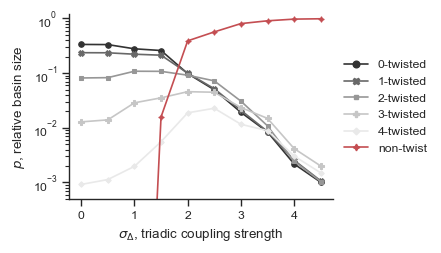

In [5]:
# labels = [f"{i}-twisted" for i in range(5)] + ["other"]
labels = [i for i in df[mask_pos * mask_nobig].state.unique() if "twisted" in i] + [
    "non-twist"
]

fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df[mask_pos * mask_nobig],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="state",
    dashes=False,
    # hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(labels) - 1) + ["r"],
)

g.set(yscale="log")
sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="")

ax.set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
ax.set_ylim(ymin=5e-4, ymax=1.2)

# plt.savefig(f"{results_dir}figure_2.pdf", dpi=250, bbox_inches="tight")

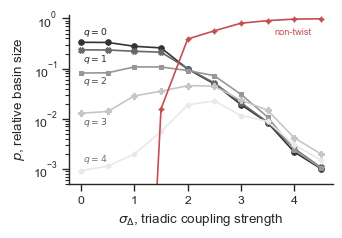

In [9]:
# labels = [f"{i}-twisted" for i in range(5)] + ["other"]
labels = [i for i in df[mask_pos * mask_nobig].ostate.unique() if "q" in i] + [
    "non-twist"
]

fig, ax = plt.subplots(figsize=(3.4, 2.2))
g = sb.lineplot(
    data=df[mask_pos * mask_nobig],
    x="k2",
    y="proba",
    hue="ostate",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="state",
    dashes=False,
    # hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(labels) - 1) + ["r"],
    legend=False,
)

g.set(yscale="log")

ax.set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
ax.set_ylim(ymin=5e-4, ymax=1.2)

colors = sb.color_palette("Greys_r", n_colors=len(labels) - 1)
heights = [0.13, 0.35, 0.59, 0.72, 0.88][::-1]
for i in range(len(labels) - 1):
    ax.text(
        0.1,
        heights[i],
        rf"{labels[i]}",
        transform=ax.transAxes,
        ha="center",
        fontsize="x-small",
        c="k",
        alpha=1 - i * 0.1,
    )

ax.text(
    0.85,
    0.88,
    rf"{labels[-1]}",
    transform=ax.transAxes,
    ha="center",
    fontsize="x-small",
    c="r",
)

#plt.savefig(f"{results_dir}figure_2.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_2.png", dpi=250, bbox_inches="tight", pad_inches=0.03)

## Harmonics

In [104]:
N = 100
nreps = 10000
suf = "ring_harmonics"  # "di"

In [105]:
run_dir = f"{results_dir}run_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}/"
file_name = f"{run_dir}df_long_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.csv"
df = pd.read_csv(file_name, index_col=0)


df

,k2,state,proba
0,0.0,-1-twisted,0.2268
1,0.5,-1-twisted,0.1760
2,1.0,-1-twisted,NaN
3,1.5,-1-twisted,NaN
4,2.0,-1-twisted,NaN
...,...,...,...
121,2.0,2-cluster,0.3246
122,2.5,2-cluster,0.3135
123,3.0,2-cluster,0.3125
124,3.5,2-cluster,0.3120


In [106]:
df["q"] = df["state"].apply(lambda x: int(x[:-8]) if "twisted" in x else None)
df["k"] = df["state"].apply(lambda x: int(x[:-8]) if "cluster" in x else None)

df["state"] = df["state"].replace("sync", "0-twisted")

df


,k2,state,proba,q,k
0,0.0,-1-twisted,0.2268,-1.0,NaN
1,0.5,-1-twisted,0.1760,-1.0,NaN
2,1.0,-1-twisted,NaN,-1.0,NaN
3,1.5,-1-twisted,NaN,-1.0,NaN
4,2.0,-1-twisted,NaN,-1.0,NaN
...,...,...,...,...,...
121,2.0,2-cluster,0.3246,NaN,2.0
122,2.5,2-cluster,0.3135,NaN,2.0
123,3.0,2-cluster,0.3125,NaN,2.0
124,3.5,2-cluster,0.3120,NaN,2.0


In [107]:
mask_pos = (df["q"] >= 0) + (df["q"].isna())
mask_nobig = (98 < df["q"]) + (df["q"] < 4) + (df["q"].isna())

df[mask_pos * mask_nobig].state.unique()

In [108]:
df[mask_pos * mask_nobig].state.unique()

array(['0-twisted', '1-twisted', '2-twisted', '3-twisted', 'other',
       '2-cluster'], dtype=object)

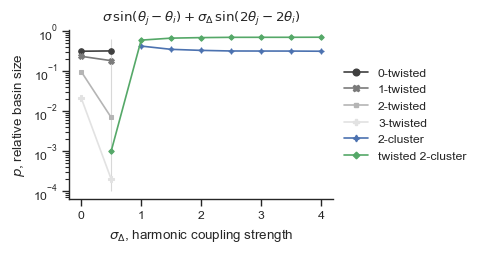

In [109]:
# labels = [f"{i}-twisted" for i in range(5)] + ["other"]
unique_states = sorted(
    [i for i in df[mask_pos * mask_nobig].state.unique() if "twisted" in i]
)

df["state"] = df["state"].replace("other", "twisted 2-cluster")

labels = unique_states + ["2-cluster", "twisted 2-cluster"]

fig, ax = plt.subplots(figsize=(3.4, 2.2))
g = sb.lineplot(
    data=df[mask_pos * mask_nobig],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="state",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["b", "g"],
    legend=True,
)

g.set(yscale="log")

ax.set_xlabel(r"$\sigma_{\Delta}$, harmonic coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
#ax.set_ylim(ymin=5e-4, ymax=1.2)

sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="")

coupling_str = r"$\sigma \, \sin (\theta_j - \theta_i) + \sigma_{\Delta} \, \sin (2\theta_j - 2\theta_i)$"
ax.set_title(coupling_str)

# plt.savefig(f"{results_dir}figure_2.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_2_{suf}.png", dpi=250, bbox_inches="tight", pad_inches=0.03)

## Asym

In [97]:
N = 100
nreps = 10000
suf = "ring_asym"  # "di"

In [98]:
run_dir = f"{results_dir}run_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}/"
file_name = f"{run_dir}df_long_k1_1_k2s_ic_random_tend_600.0_nreps_{nreps}_{suf}.csv"
df = pd.read_csv(file_name, index_col=0)


df

,k2,state,proba
0,0.0,-1-twisted,0.2329
1,0.5,-1-twisted,0.2431
2,1.0,-1-twisted,0.0079
3,1.5,-1-twisted,0.0249
4,2.0,-1-twisted,0.0002
...,...,...,...
242,5.0,sync,NaN
243,5.5,sync,NaN
244,6.0,sync,NaN
245,6.5,sync,NaN


In [99]:
df["q"] = df["state"].apply(lambda x: int(x[:-8]) if "twisted" in x else None)
df["k"] = df["state"].apply(lambda x: int(x[:-8]) if "cluster" in x else None)

df["state"] = df["state"].replace("sync", "0-twisted")

df


,k2,state,proba,q,k
0,0.0,-1-twisted,0.2329,-1.0,None
1,0.5,-1-twisted,0.2431,-1.0,None
2,1.0,-1-twisted,0.0079,-1.0,None
3,1.5,-1-twisted,0.0249,-1.0,None
4,2.0,-1-twisted,0.0002,-1.0,None
...,...,...,...,...,...
242,5.0,0-twisted,NaN,NaN,None
243,5.5,0-twisted,NaN,NaN,None
244,6.0,0-twisted,NaN,NaN,None
245,6.5,0-twisted,NaN,NaN,None


In [100]:
mask_pos = (df["q"] >= 0) + (df["q"].isna())
mask_nobig = (98 < df["q"]) + (df["q"] < 4) + (df["q"].isna())

In [101]:
df[mask_pos * mask_nobig].state.unique() 

array(['0-twisted', '1-twisted', '2-twisted', '3-twisted', 'other'],
      dtype=object)

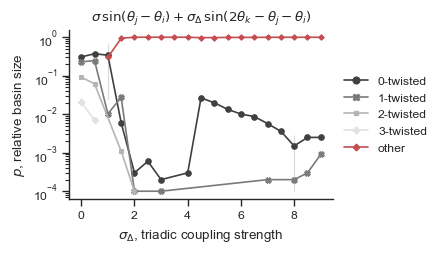

In [103]:
# labels = [f"{i}-twisted" for i in range(5)] + ["other"]
unique_states = sorted(
    [i for i in df[mask_pos * mask_nobig].state.unique() if "twisted" in i]
)
labels = unique_states + ["other"]

fig, ax = plt.subplots(figsize=(3.4, 2.2))
g = sb.lineplot(
    data=df[mask_pos * mask_nobig],
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    # alpha=0.7,
    style="state",
    dashes=False,
    hue_order=labels,
    ms=4,
    mec=None,
    # mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(unique_states)) + ["r"],
    legend=True,
)

g.set(yscale="log")

ax.set_xlabel(r"$\sigma_{\Delta}$, triadic coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
#ax.set_ylim(ymin=5e-4, ymax=1.2)

sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="")

coupling_str = r"$\sigma \, \sin (\theta_j - \theta_i) + \sigma_{\Delta} \, \sin (2\theta_k - \theta_j - \theta_i)$"
ax.set_title(coupling_str)

# plt.savefig(f"{results_dir}figure_2.pdf", dpi=250, bbox_inches="tight", pad_inches=0.03)
plt.savefig(f"{results_dir}figure_2_{suf}.png", dpi=250, bbox_inches="tight", pad_inches=0.03)